In [1]:
import os
import random
import gc
import time
import re
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, precision_recall_curve, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
import warnings
import matplotlib.pyplot as plt
from collections import Counter
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/OpenClassRooms/"

In [5]:
# FOnction de one-hot encoding pour les colonnes catégories avec get dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [6]:
# Preprocessing des données "application train et test"
def application_train_test(num_rows = None, nan_as_category = False):
    # Lecture et merge des données
    df = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test_df = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
    # Suppréssion de XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Encoding pour les features catégoriques binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # One-Hot encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Remplacement des NaN values pour DAYS_EMPLOYED: 365.243
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Création de nouvelles features (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [7]:
# Preprocessing de bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows = num_rows)
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Aggréger et fusionner avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Calcul de plusieurs features numériques sur bureau.csv
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Identification des categorical features de bureau.csv et bureau_balance.csv
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: credits actifs - en utilisant uniquement les aggrégations numériques
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: credits clos - en utilisant uniquement les aggrégations numériques
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [8]:
# Preprocessing de previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Remplacement des valeurs pour les jours supérieurs à 365.243
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Ajout d'un indicateur: valeur demandée / valeur percue pourcentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Calcul de plusieurs features numériques sur previous_applications.csv
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Gestion des categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Applications approuvées- en ne prenant que les numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Applications refusées- en ne prenant que les numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg



In [9]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Nombre de comptes
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Pourcentage et difference entre montant payé et montant de l'échéance
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Nombre de jours de retard (Past Due) ou d'avance (Before Due) par rapport à la date d'échéance
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: aggrégats
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Nombre de comptes avec échéancier
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [11]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # Aggrégats génériques
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Nombre de lignes de cartes de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [12]:
# Fonction principale
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [13]:
df=main(debug=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 45s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 39s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 20s
Installments payments df shape: (339587, 26)
Process installments payments - done in 49s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 29s


In [14]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [15]:
df=reduce_memory(df)

Initial df memory usage is 1852.64 MB for 797 columns
Final memory usage is: 650.62 MB - decreased by 64.9%


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float16(586), float32(166), float64(3), int16(2), int32(1), int8(39)
memory usage: 650.6 MB


In [17]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(df.median())

In [18]:
train = pd.read_csv(os.path.join(path, 'application_train.csv'))
test = pd.read_csv(os.path.join(path, 'application_test.csv'))

In [19]:
data = df[df['SK_ID_CURR'].isin(train.SK_ID_CURR)]
data_test = df[df['SK_ID_CURR'].isin(test.SK_ID_CURR)]

In [20]:
# Export pour réutilisation
data.to_csv("/content/drive/MyDrive/OpenClassRooms/data.csv")
data_test.to_csv("/content/drive/MyDrive/OpenClassRooms/data_test.csv")

In [21]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
print("Label 1 dans le jeu d'entrainement: {}".format(sum(y_train==1)))
print("Label 0 dans le jeu d'entrainement: {}".format(sum(y_train==0)))

Label 1 dans le jeu d'entrainement: 18569
Label 0 dans le jeu d'entrainement: 212061


In [24]:
# Sous échntillonage pour équilibrer le jeu d'entrainement
from imblearn.under_sampling import RandomUnderSampler
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [25]:
print("Label 1 dans le jeu retravaillé: {}".format(sum(y_ru==1)))
print("Label 0 dans le jeu retravaillé: {}".format(sum(y_ru==0)))

Label 1 dans le jeu retravaillé: 18569
Label 0 dans le jeu retravaillé: 18569


In [26]:
def custom_cost(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    cost = (10 * fn + fp) / len(y_true)  # Faux négatif coûte 10 fois plus cher que le faux positif
    return cost

In [27]:
# Créer une fonction scorer avec make_scorer
custom_scorer = make_scorer(custom_cost, greater_is_better=False, needs_threshold=True)

In [28]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format=".0f")
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [29]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=True):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold AUC = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [30]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict values
    y_pred = model.predict(x_test)
    y_pred_train =model.predict(X_ru)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score_test = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    clf_report_train = pd.DataFrame(classification_report(y_ru, y_pred_train, output_dict=True)).transpose()
    display(clf_report)


    return auc_score_test, clf_report, clf_report_train

In [31]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Yr29VM4O75CyEtIinQLFUnZU0l_3oLvE4D4m81BPzRv1tHtB"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
MLflow Tracking UI: https://a10f-34-80-222-194.ngrok-free.app


In [32]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None, auc_score_train=None, f1_score_train=None, acc_score_train=None,
               train_class_0=None, train_class_1=None, fit_duration=None, predict_duration=None):

    # Track params and metrics
    with mlflow.start_run(run_name="credit_scoring"):
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)
        mlflow.log_metric("AUC train", auc_score_train)
        mlflow.log_metric("F1 train", f1_score_train)
        mlflow.log_metric("Accuracy train", acc_score_train)
        mlflow.log_metric("fit_duration", fit_duration)
        mlflow.log_metric("predict_duration", predict_duration)

    mlflow.end_run()

In [33]:
import re

X_ru.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_ru.columns]
X_test.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_ru.columns]

In [34]:
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.01, 1.0, 0.001)
    best_custom_score = 100
    optimal_threshold = 0  # Valeur par défaut

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        custom_score=custom_cost(y_test, y_pred)

        if custom_score < best_custom_score:
            best_custom_score = custom_score
            optimal_threshold = threshold

    return optimal_threshold

In [35]:
from sklearn.dummy import DummyClassifier
#Moyenne
cls=DummyClassifier(strategy='most_frequent')
cls.fit(X_ru, y_ru)
y_pred_dum = cls.predict(X_test)

In [36]:
custom_cost(y_test, y_pred_dum)

0.8137674467005737

In [37]:
log_reg=LogisticRegression()
log_reg.fit(X_ru, y_ru)
y_pred_base = log_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
custom_cost(y_test, y_pred_base)

0.8735252416197302

In [39]:
# Recherche d'hyperparamètres
%%time
grid_search = GridSearchCV(LGBMClassifier(verbose=-1), {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 500], 'max_depth': [3, 5, 7],'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0], 'colsample_bylevel': [0.8, 1.0], 'colsample_bynode': [0.8, 1.0]}, scoring=custom_scorer, cv=5, n_jobs=-1)
grid_search.fit(X_ru, y_ru)

print(grid_search.best_params_)
print(grid_search.best_score_)

KeyboardInterrupt: 

In [40]:
%%time
grid_search = GridSearchCV(XGBClassifier(), {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 500], 'max_depth': [3, 5], 'colsample_bytree': [0.8, 1.0], 'subsample': [0.8, 1.0]}, scoring=custom_scorer, cv=5, n_jobs=-1)
grid_search.fit(X_ru, y_ru)

print(grid_search.best_params_)
print(grid_search.best_score_)

KeyboardInterrupt: 

In [41]:
best_lgbm=LGBMClassifier(verbose=-1, learning_rate=0.1, n_estimators=100, max_depth=7, subsample=1.0, colsample_bytree=1.0, colsample_bylevel=0.8, colsample_bynode=0.8)
start_time_fit = time.time()
best_lgbm.fit(X_ru, y_ru)
end_time_fit = time.time()
start_time_predict = time.time()
y_probs_lgb = best_lgbm.predict_proba(X_test)[:, 1]
end_time_predict = time.time()
best_thresholds_lgbm = find_optimal_threshold(y_test, y_probs_lgb)

In [42]:
best_thresholds_lgbm

0.5599999999999995

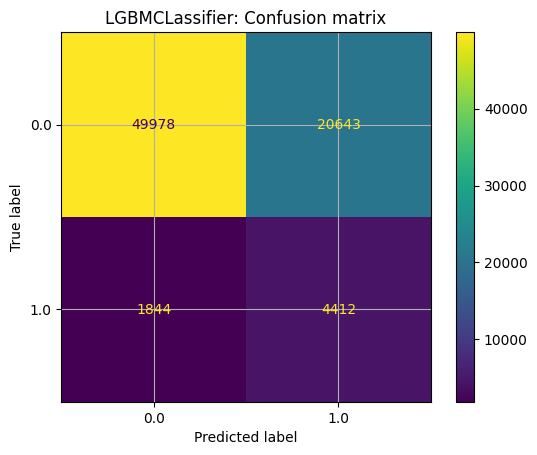

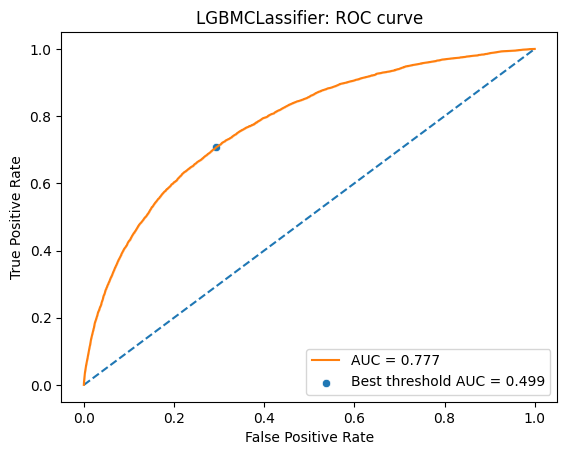

,precision,recall,f1-score,support
0.0,0.964417,0.707693,0.816347,70621.000000
1.0,0.176093,0.705243,0.281818,6256.000000
accuracy,0.707494,0.707494,0.707494,0.707494
macro avg,0.570255,0.706468,0.549083,76877.000000
weighted avg,0.900265,0.707494,0.772849,76877.000000


In [43]:
cost=custom_cost(y_test, y_probs_lgb, threshold=best_thresholds_lgbm)
auc_score, clf_report, clf_report_train = compute_classification_results(best_lgbm, "LGBMCLassifier", X_test, y_test)
y_pred_proba_train = best_lgbm.predict_proba(X_ru)[:,1]
auc_score_train = roc_auc_score(y_ru, y_pred_proba_train)

In [44]:
log_mlflow(best_lgbm, "LGBMCLassifier",
           custom_score=cost,
           auc_score=auc_score,
           f1_score=clf_report.loc['weighted avg', 'f1-score'],
           acc_score=clf_report.loc['accuracy', 'precision'],
           auc_score_train=auc_score_train,
           f1_score_train=clf_report_train.loc['weighted avg', 'f1-score'],
           acc_score_train=clf_report_train.loc['accuracy', 'precision'],
           train_class_0=Counter(y_ru)[0],
           train_class_1=Counter(y_ru)[1],
           fit_duration=end_time_fit-start_time_fit,
           predict_duration=end_time_predict-start_time_predict)

In [45]:
best_xgb=XGBClassifier(colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 3, n_estimators= 500, subsample= 1.0)
start_time_fit = time.time()
best_xgb.fit(X_ru, y_ru)
end_time_fit = time.time()
start_time_predict = time.time()
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
end_time_predict = time.time()
best_thresholds_xgb = find_optimal_threshold(y_test, y_probs_xgb)

In [46]:
best_thresholds_xgb

0.5239999999999996

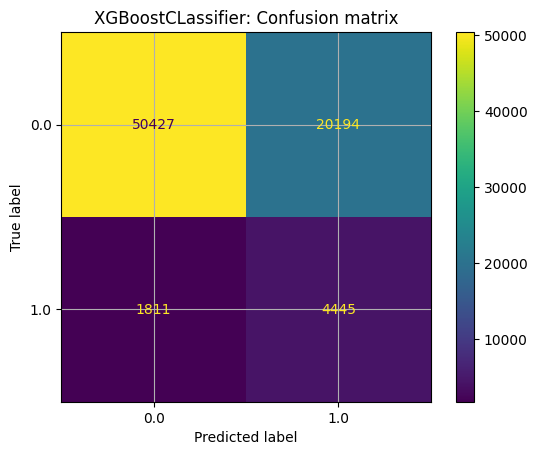

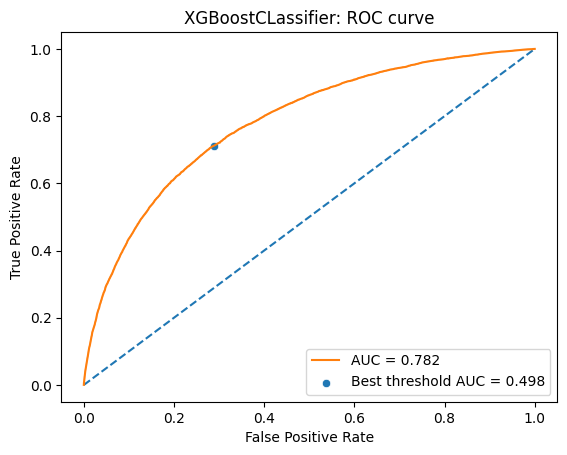

,precision,recall,f1-score,support
0.0,0.965332,0.714051,0.820892,70621.000000
1.0,0.180405,0.710518,0.287749,6256.000000
accuracy,0.713764,0.713764,0.713764,0.713764
macro avg,0.572868,0.712284,0.554321,76877.000000
weighted avg,0.901457,0.713764,0.777507,76877.000000


In [47]:
cost=custom_cost(y_test, y_probs_xgb, threshold=best_thresholds_xgb)
auc_score, clf_report, clf_report_train = compute_classification_results(best_xgb, "XGBoostCLassifier", X_test, y_test)
y_pred_proba_train = best_xgb.predict_proba(X_ru)[:,1]
auc_score_train = roc_auc_score(y_ru, y_pred_proba_train)

In [48]:
log_mlflow(best_xgb, "XGBoostCLassifier",
           custom_score=cost,
           auc_score=auc_score,
           f1_score=clf_report.loc['weighted avg', 'f1-score'],
           acc_score=clf_report.loc['accuracy', 'precision'],
           auc_score_train=auc_score_train,
           f1_score_train=clf_report_train.loc['weighted avg', 'f1-score'],
           acc_score_train=clf_report_train.loc['accuracy', 'precision'],
           train_class_0=Counter(y_ru)[0],
           train_class_1=Counter(y_ru)[1],
           fit_duration=end_time_fit-start_time_fit,
           predict_duration=end_time_predict-start_time_predict)

In [49]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.6 MB/s eta 0:00:00


In [50]:
shap.initjs()

In [51]:
# compute SHAP values
explainer= shap.TreeExplainer(best_lgbm)
shap_values = explainer(X_test)

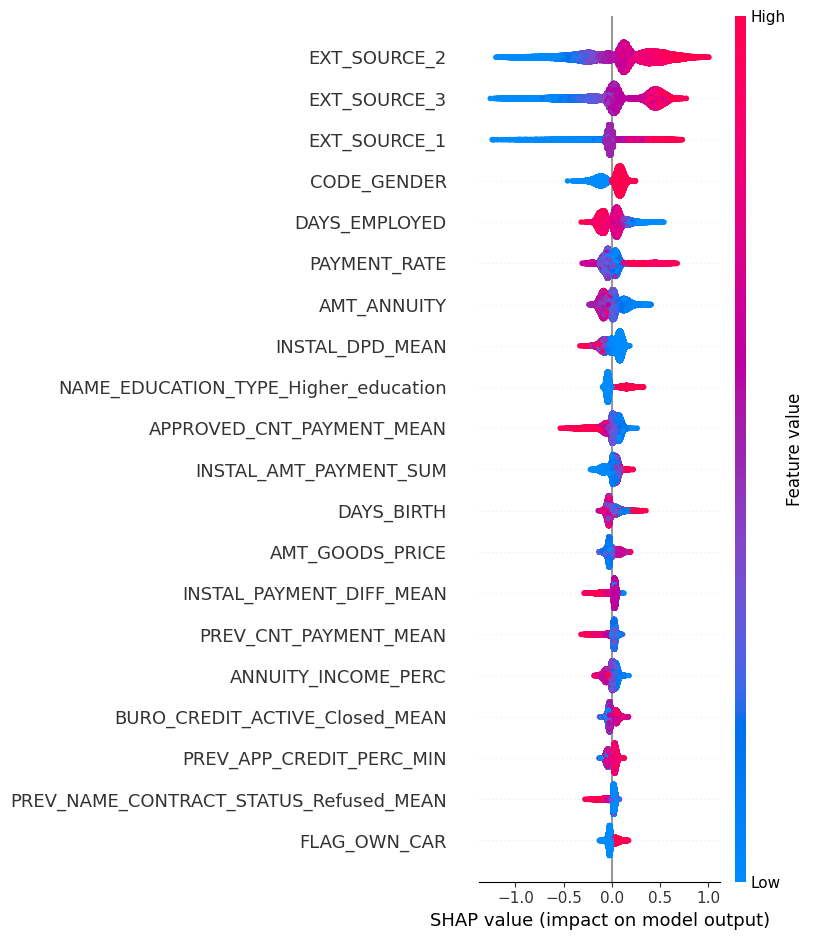

In [52]:
shap.summary_plot(shap_values.values[:,:,0], X_test)

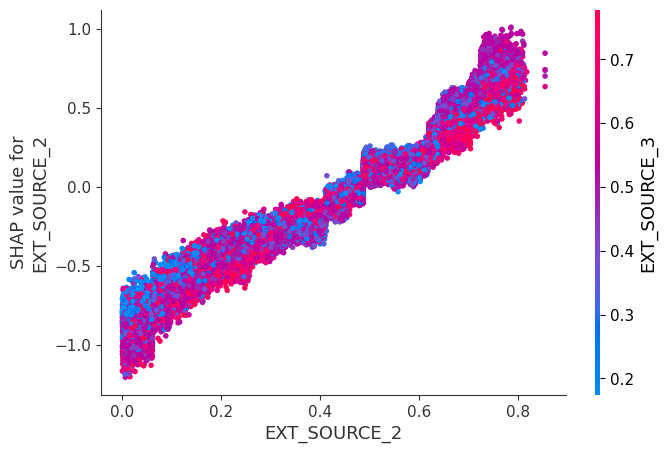

In [53]:
shap.dependence_plot("EXT_SOURCE_2", shap_values.values[:,:,0], X_test)

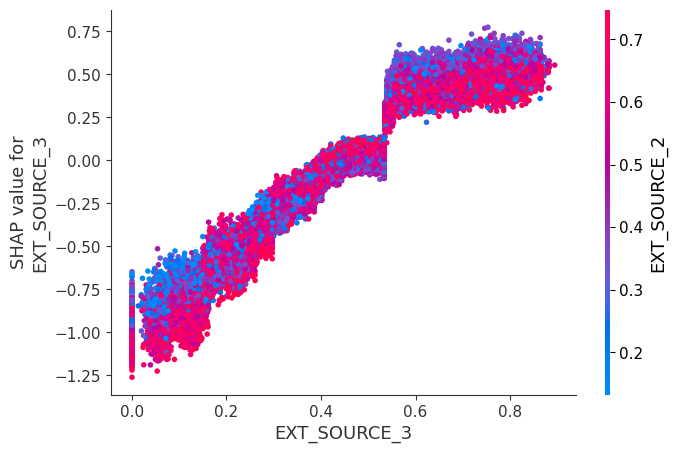

In [54]:
shap.dependence_plot("EXT_SOURCE_3", shap_values.values[:,:,0], X_test)

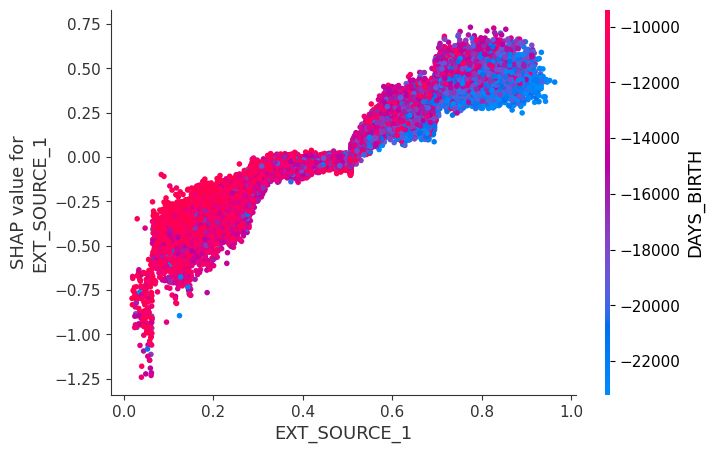

In [55]:
shap.dependence_plot("EXT_SOURCE_1", shap_values.values[:,:,0], X_test)

# **Interprétation locale**

Client numero :  64022


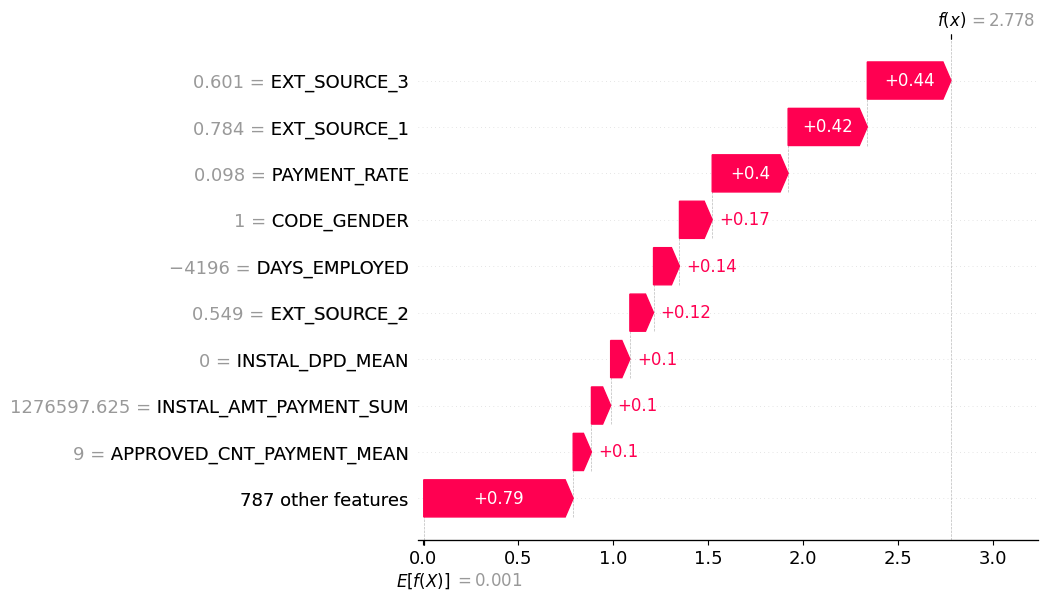

In [56]:
idx = random.randint(1, len(X_test))
print("Client numero : ", idx)
exp = shap.Explanation(shap_values.values[:,:,0], shap_values.base_values[:,0], data=X_test.values, feature_names=X_test.columns)
shap.plots.waterfall(exp[idx])

Client numero :  14916


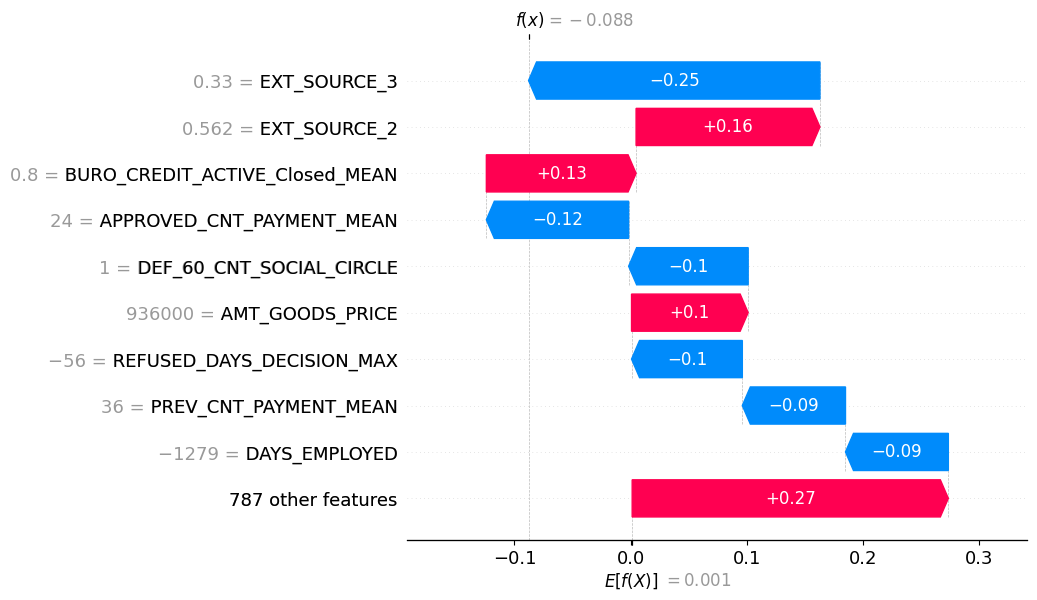

In [57]:
idx = random.randint(1, len(X_test))
print("Client numero : ", idx)
exp = shap.Explanation(shap_values.values[:,:,0], shap_values.base_values[:,0], data=X_test.values, feature_names=X_test.columns)
shap.plots.waterfall(exp[idx])

#Sauvegarde des fichiers pour réutilisation dans le dashboard

In [58]:
# Calcul de la probabilité que le client ne fasse pas défaut (valeur=0) et ajout au dataset pour export
score = best_lgbm.predict_proba(data.drop('TARGET', axis=1))[:,0]
data.loc[:, 'score']=score


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
# Création d'un échantillon pour utilisation dans le dashboard
data_sample=data.sample(n=10000)
data_sample.to_csv("/content/drive/MyDrive/OpenClassRooms/data_sample.csv")

In [60]:
data_p=data_sample.drop(['TARGET', 'score'], axis=1)

In [61]:
# Calculer les shap values des data pour intégration dans le dashboard
sv= explainer(data_p)
exp = shap.Explanation(sv.values[:,:,0], sv.base_values[:,0], data=data_p.values, feature_names=data_p.columns)

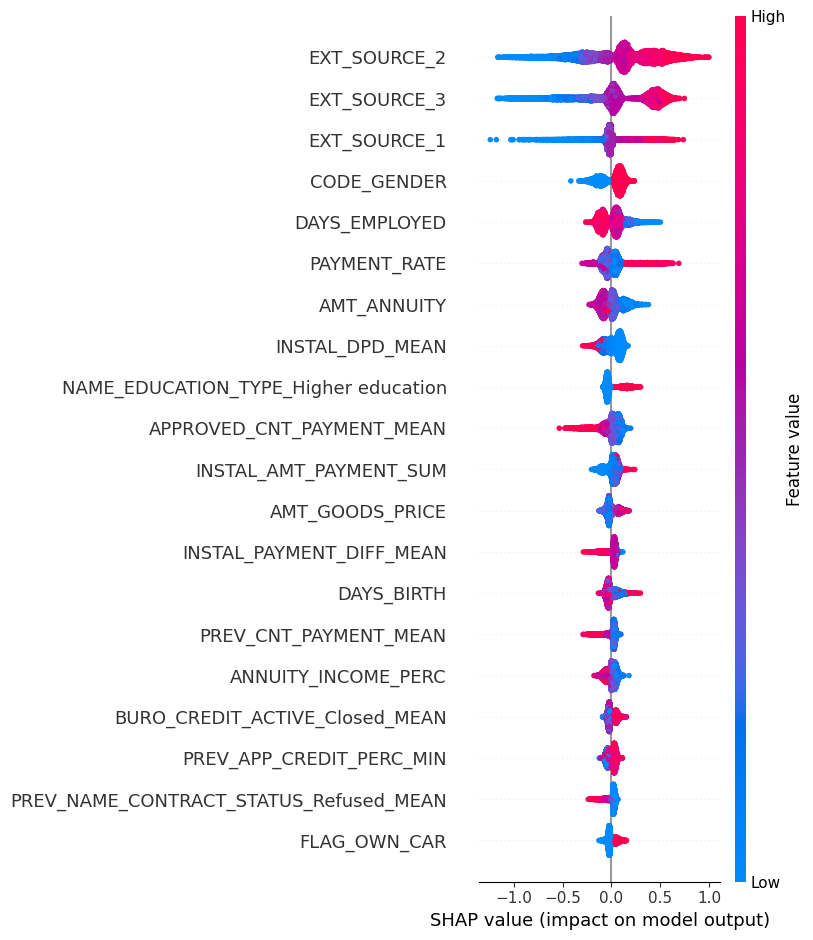

In [62]:
# sauvegarde de l'image de la feature importance globale pour les data test
fig=shap.summary_plot(sv.values[:,:,0], data_p, show=False)
plt.savefig("/content/drive/MyDrive/OpenClassRooms/sum_plot.png")

In [63]:
# Export du fichier pickle avec le modèle utilisé
import pickle
pickle_out = open("/content/drive/MyDrive/OpenClassRooms/lgbm.pkl","wb")
pickle.dump(best_lgbm, pickle_out)
pickle_out.close()

In [64]:
# Export des shap explanation locales
pickle_out = open("/content/drive/MyDrive/OpenClassRooms/exp.pkl","wb")
pickle.dump(exp, pickle_out)
pickle_out.close()

In [65]:
# Export du threshold de prédiction
pickle_out = open("/content/drive/MyDrive/OpenClassRooms/threshold.pkl","wb")
pickle.dump(best_thresholds_lgbm, pickle_out)
pickle_out.close()